In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts.models import NBEATSModel
from darts import TimeSeries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt



/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df_orig = pd.read_csv('./data/preprocessed_football.csv')
df_orig = df_orig[df_orig['Comp'] == 0]
df_orig = df_orig[df_orig['Squad'] == 3]
df = df_orig.drop(['Comp', 'LgRank', 'Attendance', 'Goalkeeper', 'Top Team Scorers', 'Top Team Goals', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'MP', 'Squad'], axis=1)

df.iloc[1:, :]
df['Season_n'] = df['Season'].to_numpy()[::-1]
df['Pts_n'] = df['Pts'].to_numpy()[::-1]
df = df.iloc[:-1, :]
df = df[['Season_n', 'Pts_n']]
print(df)


     Season_n  Pts_n
283      1988   62.0
284      1989   62.0
285      1990   46.0
286      1991   54.0
287      1992   57.0
288      1993   45.0
289      1994   55.0
290      1995   70.0
291      1996   92.0
292      1997   63.0
293      1998   68.0
294      1999   62.0
295      2000   80.0
296      2001   66.0
297      2002   78.0
298      2003   70.0
299      2004   80.0
300      2005   70.0
301      2006   76.0
302      2007   85.0
303      2008   78.0
304      2009   96.0
305      2010   92.0
306      2011  100.0
307      2012   85.0
308      2013   87.0
309      2014   92.0
310      2015   90.0
311      2016   93.0
312      2017   76.0
313      2018   68.0
314      2019   87.0
315      2020   84.0
316      2021   86.0
317      2022   78.0


In [3]:
n_splits = 5
df, df_test = train_test_split(df, random_state=123, shuffle=False, test_size=0.15)
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform time series cross-validation
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Use auto_arima to automatically select the best SARIMAX model
    model = auto_arima(train['Pts_n'], seasonal=True, m=1)  # Adjust m (seasonal period) accordingly

    # Fit the model on the training data
    fitted_model = model.fit(train['Pts_n'])

    # Make predictions on the test set
    predictions = fitted_model.predict(len(test))

    # Calculate Mean Squared Error (MSE) as the evaluation metric
    rmse = mean_squared_error(test['Pts_n'], predictions) ** 0.5

    # Print or store the MSE for each fold
    print(f'Root Mean Squared Error for Fold: {rmse}')

# You can also calculate and print the average MSE across all folds
average_rmse = np.mean(rmse)
print(f'Average Root Mean Squared Error across all Folds: {average_rmse}')


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error for Fold: 10.670572201672748


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error for Fold: 12.161390063805335


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error for Fold: 11.916323379806725


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error for Fold: 16.144361749399987
Root Mean Squared Error for Fold: 2.3681095600596787
Average Root Mean Squared Error across all Folds: 2.3681095600596787


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [4]:
print(fitted_model.order)
print(fitted_model.seasonal_order)

(0, 1, 1)
(0, 0, 0, 0)


29    93.0
30    93.0
31    93.0
32    93.0
33    93.0
34    93.0
Name: predicted_mean, dtype: float64


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko

<Axes: >

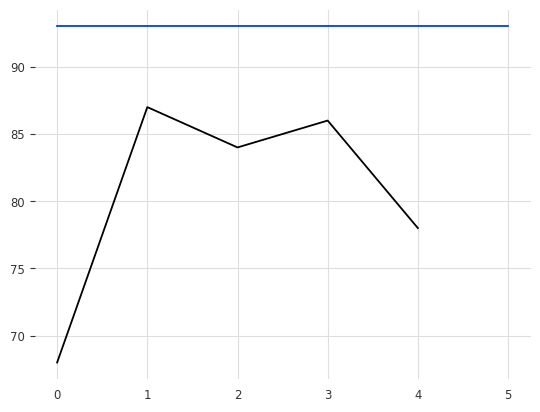

In [5]:
model = ARIMA(df['Pts_n'], order=(0,1,0))
model.initialize_approximate_diffuse()

model = model.fit()

res = model.forecast(steps=len(df_test))
print(res)

plt.figure()
sns.lineplot(df_test['Pts_n'][-5:].tolist())
sns.lineplot(res.tolist())

In [6]:
df = df_orig.drop(['Squad', 'Comp', 'Attendance', 'Goalkeeper', 'Top Team Scorers', 'Top Team Goals'], axis=1)

# df['Season_n'] = df['Season'].to_numpy()[::-1]
# df['Pts_n'] = df['Pts'].to_numpy()[::-1]
df = df.iloc[::-1, :]
df = df.iloc[:-1, :]
df.drop(['Season'], axis=1, inplace=True)
scale_w = np.full((len(df), 1), fill_value=3)
scale_w[:7] = 2
df['Scale_w'] = scale_w
print(df.head(10))


     LgRank    MP     W     D     L     GF    GA    GD   Pts  Scale_w
318     1.0  38.0  25.0  12.0   1.0   91.0  37.0  54.0  62.0        2
317     1.0  38.0  26.0  10.0   2.0  107.0  38.0  69.0  62.0        2
316     3.0  38.0  20.0   6.0  12.0   63.0  37.0  26.0  46.0        2
315     2.0  38.0  23.0   8.0   7.0   78.0  32.0  46.0  54.0        2
314     2.0  38.0  24.0   9.0   5.0   75.0  28.0  47.0  57.0        2
313     4.0  38.0  19.0   7.0  12.0   61.0  50.0  11.0  45.0        2
312     1.0  38.0  23.0   9.0   6.0   76.0  29.0  47.0  55.0        2
311     6.0  42.0  20.0  10.0  12.0   75.0  51.0  24.0  70.0        3
310     1.0  42.0  27.0  11.0   4.0   85.0  36.0  49.0  92.0        3
309     4.0  38.0  17.0  12.0   9.0   63.0  45.0  18.0  63.0        3


In [7]:
def predict_exo(train_exo, method, val_len, X_val=None, plot=True, p=10, d=1, q=1):
    result = pd.DataFrame()
    for col in train_exo.columns:
        if method == "arima":
            model = ARIMA(train_exo[col], order=(p,d,q))
            model.initialize_approximate_diffuse()
            model = model.fit()
            forecast = model.forecast(steps=val_len)
            result[col] = forecast
            if plot:
                plt.figure()
                sns.lineplot(data=train_exo[col], label=col)
                sns.lineplot(data=forecast, label='Forecast')
                sns.lineplot(data=X_val[col], label='gt')
        elif method == "texp":
            model = ExponentialSmoothing(train_exo[col], trend='add', seasonal='add', seasonal_periods=12)
            forecast = model.fit().forecast(steps=val_len)
            result[col] = forecast
            if plot:
                plt.figure()
                sns.lineplot(data=train_exo[col], label=col)
                sns.lineplot(data=forecast, label='Forecast')
                sns.lineplot(data=X_val[col], label='gt')
        elif method == "mixed":
            if col in ['Perak_Area_ma', 'Perak_Area_npa', 'Perak_Area_rpa', 'Perak_Area_ma_new']:
                model = ARIMA(train_exo[col], order=(p,d,q))
                model.initialize_approximate_diffuse()
                model = model.fit()
                forecast = model.forecast(steps=val_len)
                result[col] = forecast
            else:
                model = ExponentialSmoothing(train_exo[col], trend='add', seasonal='add', seasonal_periods=12)
                forecast = model.fit().forecast(steps=val_len)
                result[col] = forecast
            if plot:
                plt.figure()
                sns.lineplot(data=train_exo[col], label=col)
                sns.lineplot(data=forecast, label='Forecast')
                sns.lineplot(data=X_val[col], label='gt')
        else:
            raise NotImplementedError
    return result

/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary start

      LgRank    MP          W         D         L         GF         GA  \
31  2.636915  38.0  16.790211  6.732180  8.850122  41.034180  37.582522   
32  1.391216  38.0  19.159873  6.595883  7.356647  44.182538  38.325786   
33  2.222885  38.0  19.987466  5.991469  5.571920  32.651378  40.024842   
34  2.787779  38.0  19.248704  8.808632  6.900540  43.359298  44.507708   

           GD  Scale_w  
31  34.262142      3.0  
32  23.720613      3.0  
33  31.181401      3.0  
34  19.584766      3.0  
31    61.377922
32    69.104294
33    71.855315
34    69.003492
Name: predicted_mean, dtype: float64


<Axes: ylabel='Pts'>

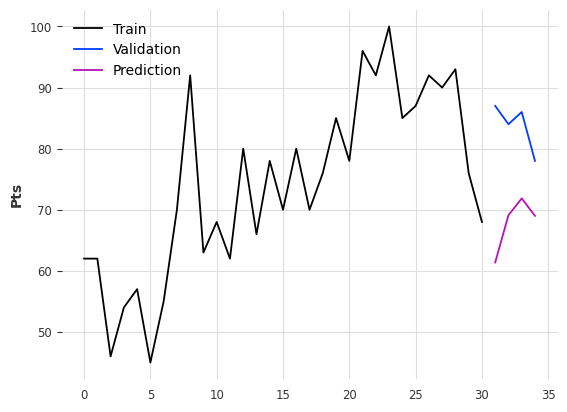

In [8]:
y = df['Pts']
X = df.drop(['Pts'], axis=1)
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = X.iloc[:-4, :], X.iloc[-4:, :], y.iloc[:-4], y.iloc[-4:]
# print(y_train)
# print(X_train)



model= SARIMAX(y_train, X_train, order=(1, 1, 5), seasonal_order=(1, 1, 2, 12))
model.initialize_approximate_diffuse()
model = model.fit(disp=False)

X_val_pred = predict_exo(X_train, 'arima', len(y_val), X_val, plot=False)
print(X_val_pred)
res = model.predict(start=len(y_train), end=len(y_train)+len(y_val)-1, exog=X_val_pred)
print(res)
plt.figure()
sns.lineplot(data=y_train, label='Train')
sns.lineplot(data=y_val, label='Validation')
sns.lineplot(data=res, label='Prediction')



# val_pred_exo = predict_exo(train_exo, 'texp', num_of_val)

/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations

31    82.105865
32    89.616722
33    92.090377
34    92.580784
Name: predicted_mean, dtype: float64
31    87.0
32    84.0
33    86.0
34    78.0
dtype: float64
31    87.0
32    84.0
33    86.0
34    78.0
Name: Pts, dtype: float64


<Axes: ylabel='Pts'>

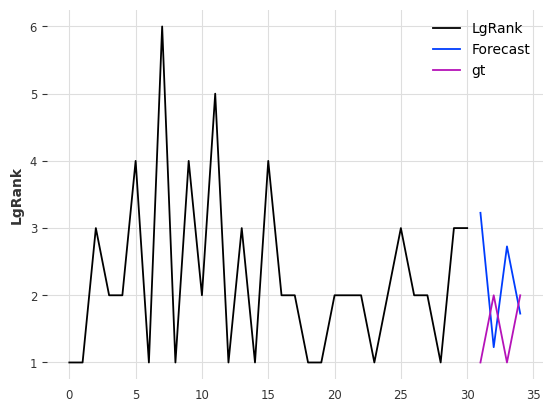

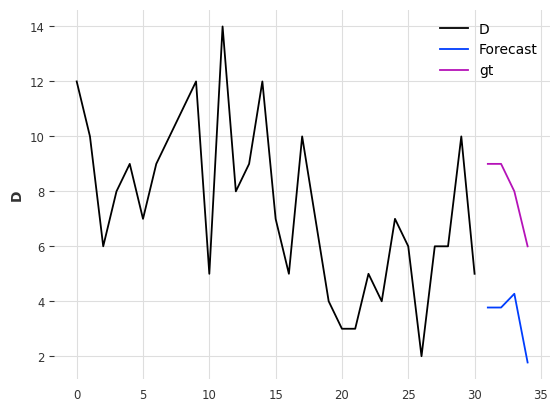

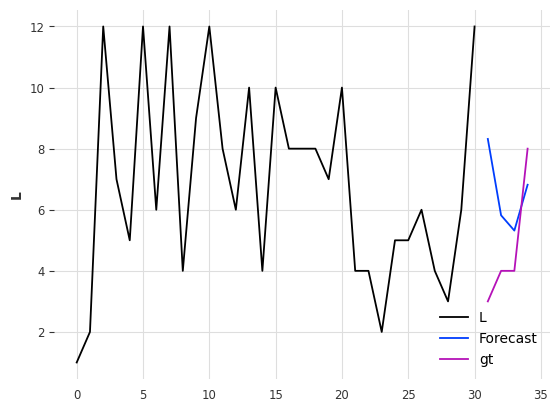

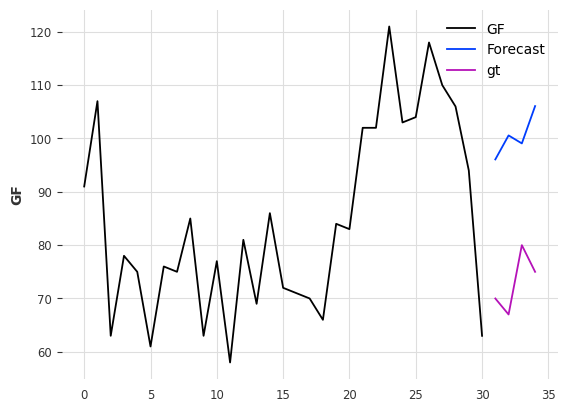

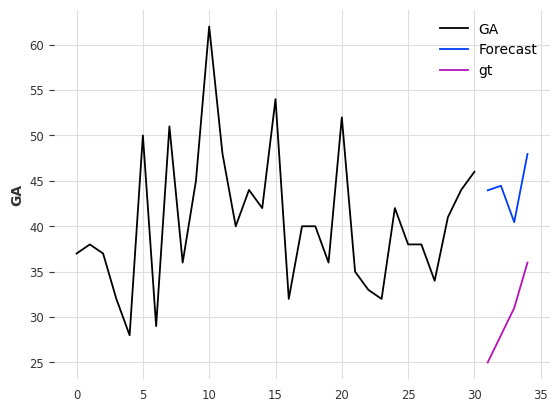

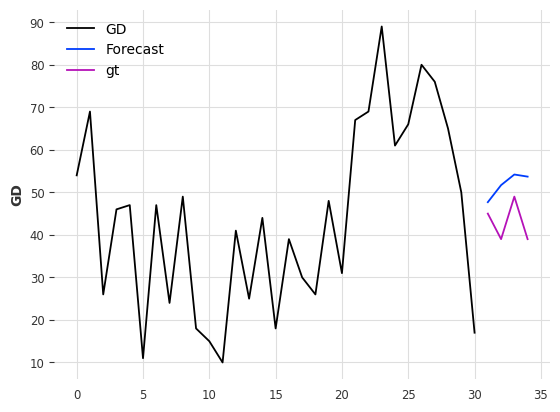

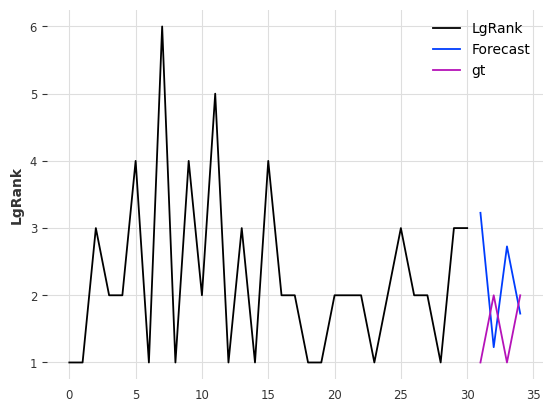

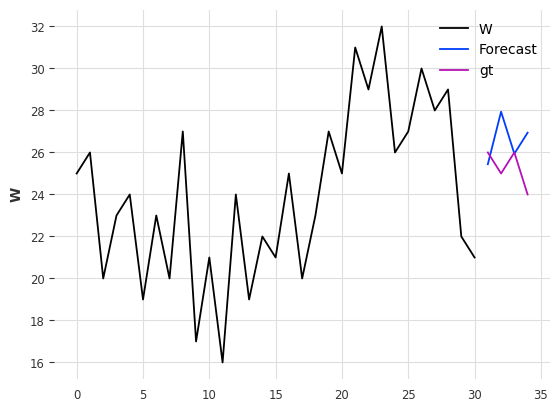

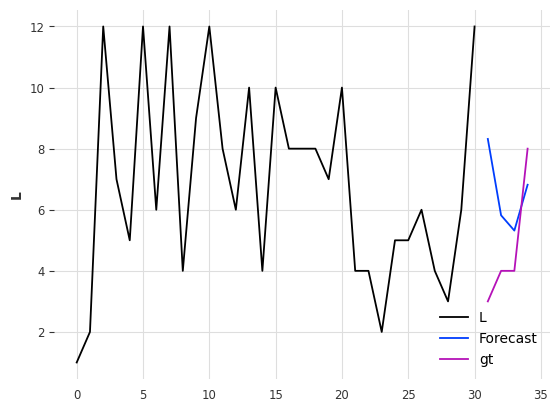

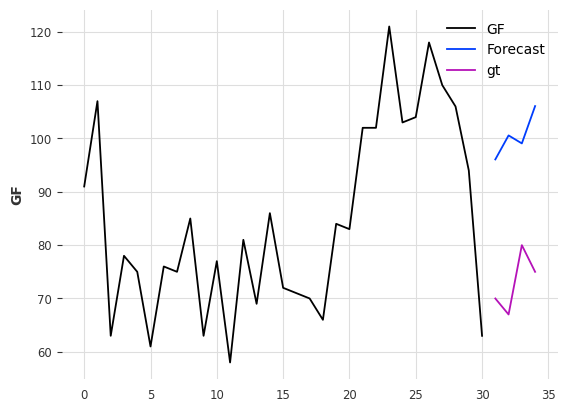

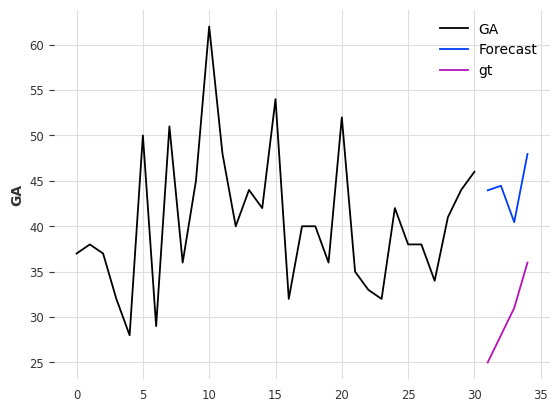

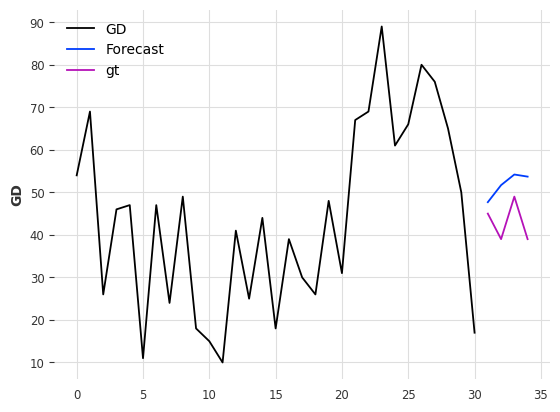

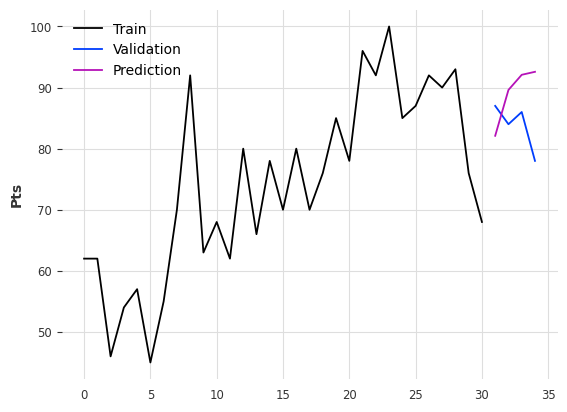

In [9]:
# Second approach (try predict wins and draws and then calculate total points by formula: P = 3W + D)

y1 = df['W']
y2 = df['D']
X = df.drop(['Pts', 'MP', 'Scale_w'], axis=1)
X1 = X.drop(['W'], axis=1)
X2 = X.drop(['D'], axis=1)
y1.reset_index(drop=True, inplace=True)
y2.reset_index(drop=True, inplace=True)
X1.reset_index(drop=True, inplace=True)
X2.reset_index(drop=True, inplace=True)
X1_train, X1_val, X2_train, X2_val, y1_train, y1_val, y2_train, y2_val = X1.iloc[:-4, :], X1.iloc[-4:, :], X2.iloc[:-4, :], X2.iloc[-4:, :], y1.iloc[:-4], y1.iloc[-4:], y2.iloc[:-4], y2.iloc[-4:]
# print(y1_train)
# print(y2_train)
# print(X_train)

# print(len(y1_train))
# print(len(X1_train))
# print(y1_train.index)
# print(X1_train.index)

model_w = SARIMAX(y1_train, X1_train, order=(4, 0, 4), seasonal_order=(1, 1, 2, 8))
model_w.initialize_approximate_diffuse()
model_w = model_w.fit(disp=False)

model_d = SARIMAX(y2_train, X2_train, order=(4, 0, 4), seasonal_order=(1, 1, 2, 8))
model_d.initialize_approximate_diffuse()
model_d = model_d.fit(disp=False)


X1_val_pred = predict_exo(X1_train, 'texp', len(y1_val), X1_val, plot=True)
X2_val_pred = predict_exo(X2_train, 'texp', len(y2_val), X2_val, plot=True)
# print(X1_val_pred)
# print(X2_val_pred)


res_w = model_w.predict(start=len(y1_train), end=len(y1_train)+len(y1_val)-1, exog=X1_val_pred)
res_d = model_d.predict(start=len(y2_train), end=len(y2_train)+len(y2_val)-1, exog=X2_val_pred)
print(res_w * 3 + res_d)
print(y1_val*3 + y2_val)
print(y_val)
# print(res_w)
# print(res_d)
final_res = pd.DataFrame()
final_res['pts'] = res_w * 3 + res_d
final_res.set_index(y1_val.index)
plt.figure()
sns.lineplot(data=y_train, label='Train')
sns.lineplot(data=y1_val*3 + y2_val, label='Validation')
sns.lineplot(data=final_res['pts'], label='Prediction')

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.365    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s, train_loss=1.100]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s, train_loss=1.100]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.365    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, train_loss=0.782]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s, train_loss=0.782]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.40it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.89it/s]


<Axes: ylabel='Pts'>

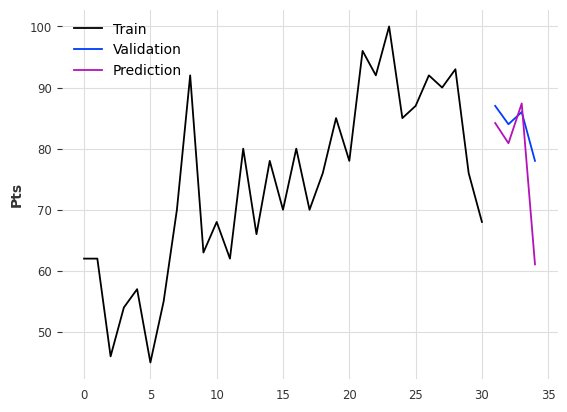

In [10]:
# Trying NBEATS

pl_trainer_kwargs = {"accelerator": "cpu"}

model_w = NBEATSModel(
        input_chunk_length=6,
        output_chunk_length=4,
        n_epochs=50,
        activation='LeakyReLU',
        pl_trainer_kwargs=pl_trainer_kwargs
        )
model_d = NBEATSModel(
        input_chunk_length=6,
        output_chunk_length=4,
        n_epochs=50,
        activation='LeakyReLU',
        pl_trainer_kwargs=pl_trainer_kwargs
        )
# y1_tr = pd.DataFrame(columns=['W'], data=y1_train)
# y2_tr = pd.DataFrame(columns=['D'], data=y2_train)

# print(len(y1_tr))
# print(len(X1_train))

y1_train = TimeSeries.from_dataframe(y1_train.to_frame(), value_cols='W')
y2_train = TimeSeries.from_dataframe(y2_train.to_frame(), value_cols='D')
X1_train = TimeSeries.from_dataframe(X1_train, value_cols=None)
X2_train = TimeSeries.from_dataframe(X2_train, value_cols=None)

model_w.fit(y1_train, past_covariates=X1_train)
model_d.fit(y2_train, past_covariates=X2_train)
wins = model_w.predict(4).values()
draws = model_d.predict(4).values()

total_pts = 3 * wins + draws
total_pts = pd.Series(total_pts[:, 0])
total_pts.index = y_val.index
plt.figure()
sns.lineplot(data=y_train, label='Train')
sns.lineplot(data=y1_val*3 + y2_val, label='Validation')
sns.lineplot(data=total_pts, label='Prediction')